## Uncertainity in Deep Learning

Taken from http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense

Also see: https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/

In [1]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
def get_data(N, min_x=0., max_x=10.):
    """Generate some dummy data with interesting properties"""
    np.random.seed(1)
    def true_model(x, e):
        alpha, beta = 4, 13
        y = (x / 10. + np.sin(alpha*(x / 10. + e)) + np.sin(beta*(x / 10. + e)) + e) * 2.
        return y
    X_obs = np.linspace(min_x, max_x, N)
    y_obs = true_model(X_obs, 0.03*np.random.rand(N))
    X_true = np.linspace(min_x - 10, max_x, 100)
    return X_obs, y_obs, X_true

In [3]:
N = 20
l2 = 0.01
X_obs, y_obs, X_true = get_data(N)
# Normalise data:
X_mean, X_std = X_obs.mean(), X_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
X_obs = (X_obs - X_mean) / X_std
y_obs = (y_obs - y_mean) / y_std
X_true = (X_true - X_mean) / X_std

In [4]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p, decay):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [5]:
model = SimpleModel(p=0.1, decay=1e-6)

In [6]:
def uncertainity_estimate(X, model, iters, l2):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_p) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [7]:
def plot_model(model, l2, iters=200, n_std=2, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2)
    
    ax.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1.)/2.),
            y_mean + y_std * ((i+1.)/2.),
            color="b",
            alpha=0.1
        )
    ax.legend()
    return ax

100%|██████████| 200/200 [00:00<00:00, 2735.80it/s]


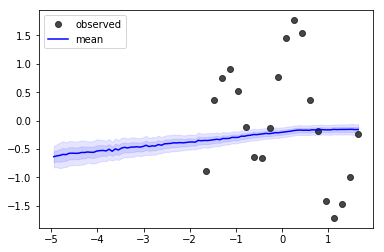

In [8]:
plot_model(model, l2, n_std=2)

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.,
    weight_decay=model.decay)

In [10]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 200/200 [00:00<00:00, 3028.29it/s]

loss=Variable containing:
1.00000e-02 *
  9.6245
[torch.FloatTensor of size 1]



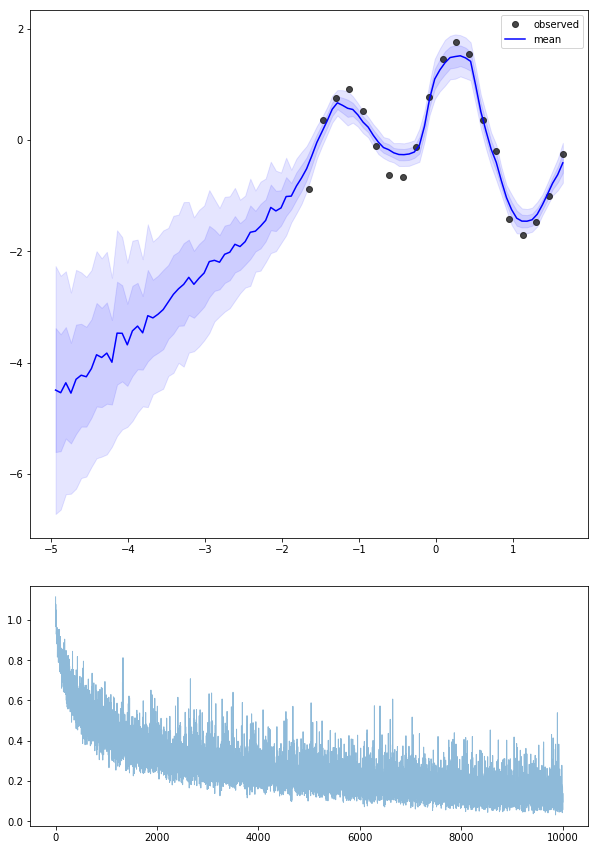

In [11]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy()[0])
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
plot_model(model, l2, ax=ax0)